<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP006_add_population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Mon Apr 18 15:43:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install timm > /dev/null
    !pip install kaggle > /dev/null
    !pip install kaggle_datasets > /dev/null
    !pip install git+https://github.com/albumentations-team/albumentations
    !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null

    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from einops.layers.torch import Rearrange, Reduce
import timm
import Levenshtein

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP006-add-population


In [54]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [122]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [259]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


# add city population

In [260]:
population_df = pd.read_csv(os.path.join(INPUT_DIR, "city_population.csv"))
population_df["City"] = population_df["Name"]

In [261]:
# 同じ都市名かつ国名のものを削除する
population_df["CC"] = population_df["Country"] + population_df["City"]
population_df["CC"].value_counts()
for k, v in population_df["CC"].value_counts().items():
    # print(k, v)
    if v > 1:
        print(f"{k} の行を削除")
        population_df = population_df[population_df["CC"] != k]

ChinaSuzhou の行を削除


In [262]:
def df_to_country_dict(df: pd.DataFrame) -> Dict:
    country_city = {}

    for t_c in set(df["Country"].tolist()):
        country_city[t_c] = []

    for country, city in zip(df["Country"], df["City"]):
        country_city[country].append(city)

    for k, v in country_city.items():
        country_city[k] = set(v)

    return country_city
    

In [263]:
train_country_city = df_to_country_dict(pd.concat([train_df, test_df]))

p_country_city = df_to_country_dict(population_df)

In [264]:
def cal_leven(str1: str, str2: str) -> float:
    # レーベンシュタイン距離の取得
    lev_dist = Levenshtein.distance(str1, str2)
    # 標準化(長い方の文字列の長さで割る)
    divider = len(str1) if len(str1) > len(str2) else len(str2)
    lev_dist = lev_dist / divider
    # 指標を合わせる(0:完全不一致 → 1:完全一致)
    return 1 - lev_dist

In [265]:
city_pairs = {}

for t_k, t_values in train_country_city.items():
    for p_k, p_values in p_country_city.items():
        # countryが一致
        if t_k != p_k:
            continue
        for t_v in t_values:
            max_score = -1
            for p_v in p_values:
                score = cal_leven(t_v, p_v)
                if max_score < score:
                    pairs = [t_v, p_v]
                    max_score = score

            if max_score > 0.8:
                city_pairs[pairs[1]] = pairs[0]
print(f"pair cities:{len(city_pairs)}")

pair cities:177


In [266]:
a = population_df["City"]
for key, value in city_pairs.items():
    # print(key, value)
    a = copy.deepcopy(a.replace(key, value))

population_df["City"] = a

In [267]:
train_df

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,195937,2021,12,31,United States,Jacksonville,30.33218,-81.65565,12,0.694,...,2.195,2.710,6.125,3.757,12,16.774,22.679,26.058,13.252,16.150
195937,195938,2021,12,31,United States,Las Vegas,36.17497,-115.13722,14,0.528,...,1.002,2.974,6.861,8.354,12,10.432,14.741,15.827,7.078,16.895
195938,195939,2021,12,31,United States,Milwaukee,43.03890,-87.90647,171,1.975,...,0.994,1.087,2.578,0.612,26,2.049,3.531,6.686,5.286,86.299
195939,195940,2021,12,31,Vietnam,Hanoi,21.02450,105.84117,31,2.613,...,1.005,3.058,6.005,6.085,51,1.922,7.443,7.716,4.642,36.523


In [268]:
if not "Prev" in train_df.columns:
    train_df = train_df.merge(population_df[["rank", "City", "Country", "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
    test_df = test_df.merge(population_df[["rank", "City", "Country",  "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")

assert len(test_df) == len(sample_df)

In [269]:
# Config
NUM_FOLDS = 5

In [270]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [271]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [272]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,rank,Population,Prev,Growth
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,17,7.671,10.358,15.112,13.424,19.901,201.0,2472222.0,2439467.0,0.0134
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,62,21.324,23.813,24.221,2.021,13.741,NaN,NaN,NaN,NaN
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,22,10.309,13.133,15.422,6.355,25.918,79.0,5150766.0,5061439.0,0.0176
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,116,7.146,10.685,13.344,9.417,174.370,NaN,NaN,NaN,NaN
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,93,1.091,3.277,12.272,4.109,167.063,242.0,2092649.0,2067333.0,0.0122


In [273]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


In [275]:
kf = GroupKFold(n_splits = NUM_FOLDS)

if not "kfold" in train_df.columns:
    folds = copy.deepcopy(train_df[["id"]])
    folds["kfold"] = -1

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
        print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
        folds.loc[valid_idx, "kfold"] = fold

    train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

# Train

In [276]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [277]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [278]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df_ = copy.deepcopy(df)
    # 経度をcosに変換
    cnt = 0

    df_["lon_cos"] = np.cos(np.radians((df_["lon"] + 180)))
    df_["lon_sin"] = np.sin(np.radians((df_["lon"] + 180)))
    df_["month_cos"] = np.cos(np.radians(df_["month"] / 12 * 360))
    df_["month_sin"] = np.sin(np.radians(df_["month"] / 12 * 360))
    cnt += 4

    # 四則演算

    # 南半球を北半球のmonthに変更
    df_["month_world"] = df_["month"]
    df_.loc[df_["lat"] < 0, "month_world"] = df_["month"] + 6
    df_.loc[df_["month_world"] > 12, "month_world"] = df_["month"] - 6

    cnt += 1
    # mid同士を4則
    columns = df_.columns
    mids = []
    for c in columns:
        if "_mid" in c and c != "pm25_mid":
            mids.append(c)
    scaler = MinMaxScaler()
    
    # scaling_columns = []
    # for i in range(len(mids)):
    #     for j in range(i):
    #         df_[f"{mids[i]}x{mids[j]}"] = df_[mids[i]] * df_[mids[j]]
    #         df_[f"{mids[i]}/{mids[j]}"] = df_[mids[i]] / (df_[mids[j]] + 1e-6)
    #         df_[f"{mids[i]}+{mids[j]}"] = df_[mids[i]] + df_[mids[j]]
    #         df_[f"{mids[i]}-{mids[j]}"] = df_[mids[i]] - df_[mids[j]]
    #         cnt += 4

    #         scaling_columns += [f"{mids[i]}x{mids[j]}", f"{mids[i]}/{mids[j]}", f"{mids[i]}+{mids[j]}", f"{mids[i]}-{mids[j]}"]
    print(f"add {cnt} columns")

    # df_[scaling_columns] = scaler.fit_transform(df_[scaling_columns])

    print("scaled columns")

    return df_

In [279]:
test_df_ = preprocess(test_df)

add 5 columns
scaled columns


In [280]:
train_df_ = preprocess(train_df)
test_df_ = preprocess(test_df)

add 5 columns
scaled columns
add 5 columns
scaled columns


In [281]:
train_df_.head(20)

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,rank,Population,Prev,Growth,kfold,lon_cos,lon_sin,month_cos,month_sin,month_world
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,201.0,2472222.0,2439467.0,0.0134,0,0.891229,-0.453554,0.866025,0.5,7
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,NaN,NaN,NaN,NaN,2,0.653973,-0.756518,0.866025,0.5,7
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,79.0,5150766.0,5061439.0,0.0176,2,0.818785,-0.574101,0.866025,0.5,7
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,NaN,NaN,NaN,NaN,1,0.881139,-0.472857,0.866025,0.5,7
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,242.0,2092649.0,2067333.0,0.0122,1,0.436196,-0.899852,0.866025,0.5,7
5,6,2019,1,1,Australia,Wollongong,-34.42400,150.89345,179,4.554,...,NaN,NaN,NaN,NaN,0,0.873717,-0.486435,0.866025,0.5,7
6,7,2019,1,1,Belgium,Antwerpen,51.22047,4.40026,93,4.011,...,NaN,NaN,NaN,NaN,3,-0.997052,-0.076724,0.866025,0.5,1
7,8,2019,1,1,Belgium,Charleroi,50.41136,4.44448,11,0.096,...,NaN,NaN,NaN,NaN,3,-0.996993,-0.077493,0.866025,0.5,1
8,9,2019,1,1,Belgium,Liège,50.63373,5.56749,12,0.097,...,NaN,NaN,NaN,NaN,0,-0.995283,-0.097018,0.866025,0.5,1
9,10,2019,1,1,Brazil,São Paulo,-23.54750,-46.63611,354,1.048,...,5.0,22429800.0,22237472.0,0.0086,0,-0.686629,0.727008,0.866025,0.5,7


In [282]:
# numericals = Numericals()
# 数字に関する変換
# train_df_num = numericals.transform(train_df)

# ラベルに関する変換
# labelencoding = LabelEncoding(columns = [])

# labelencoding.fit(train_df_num)
# train_df_labeled = labelencoding.transform(train_df_num)

In [283]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"


class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [284]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(20, 10))

    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lgbm_importances-01.png')

In [285]:
params= {
            'boosting': 'gbdt',
            'objective': 'rmse',
            'metric': 'rmse',
            'max_bin': 255,
            'learning_rate': 0.03,
            'max_depth': 8,
            'num_leaves': 8,
            'subsample': 0.7,
            'subsample_freq': 1,
            "min_data_in_leaf":30, 
            "device": "gpu",  
            "seed":2022
}

train_params = {
    "num_boost_round": 10000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 200, verbose=True),
                  lgb.log_evaluation(period = 500)
    ]
}

In [286]:
model = get_tree_model("lgb")()

cat_cols = [c for c in train_df_.columns if train_df_[c].dtype == np.object]

num_cols = [c for c in train_df_.columns if train_df_[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [287]:
models = []

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

for i in range(NUM_FOLDS):
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)

    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    model.train(
        params = params,
        train_params = train_params,
        X_train = train_data[num_cols],
        y_train = train_data[target_cols],
        X_val = valid_data[num_cols],
        y_val = valid_data[target_cols],
    )
    models.append(model)


    feature_importance = pd.DataFrame()
    feature_importance["feature"] = model.feature_names_
    feature_importance["importance"] = model.feature_importances_
    feature_importance["fold"] = i

    oof = model.predict(
        valid_data[num_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

train_data nums: 156755, valid_data nums: 39186
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12737
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 59
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 59 dense feature groups (8.97 MB) transferred to GPU in 0.007016 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 21.0168	valid_1's rmse: 25.5377
[1000]	training's rmse: 20.1578	valid_1's rmse: 24.9335
[1500]	training's rmse: 19.6714	valid_1's rmse: 24.7211
[2000]	training's rmse: 19.3162	valid_1's rmse: 24.6016
[2500]	training's rmse: 19.0248	valid_1's rmse: 24.5503
Early stopping, best iteration is:
[2357]	t

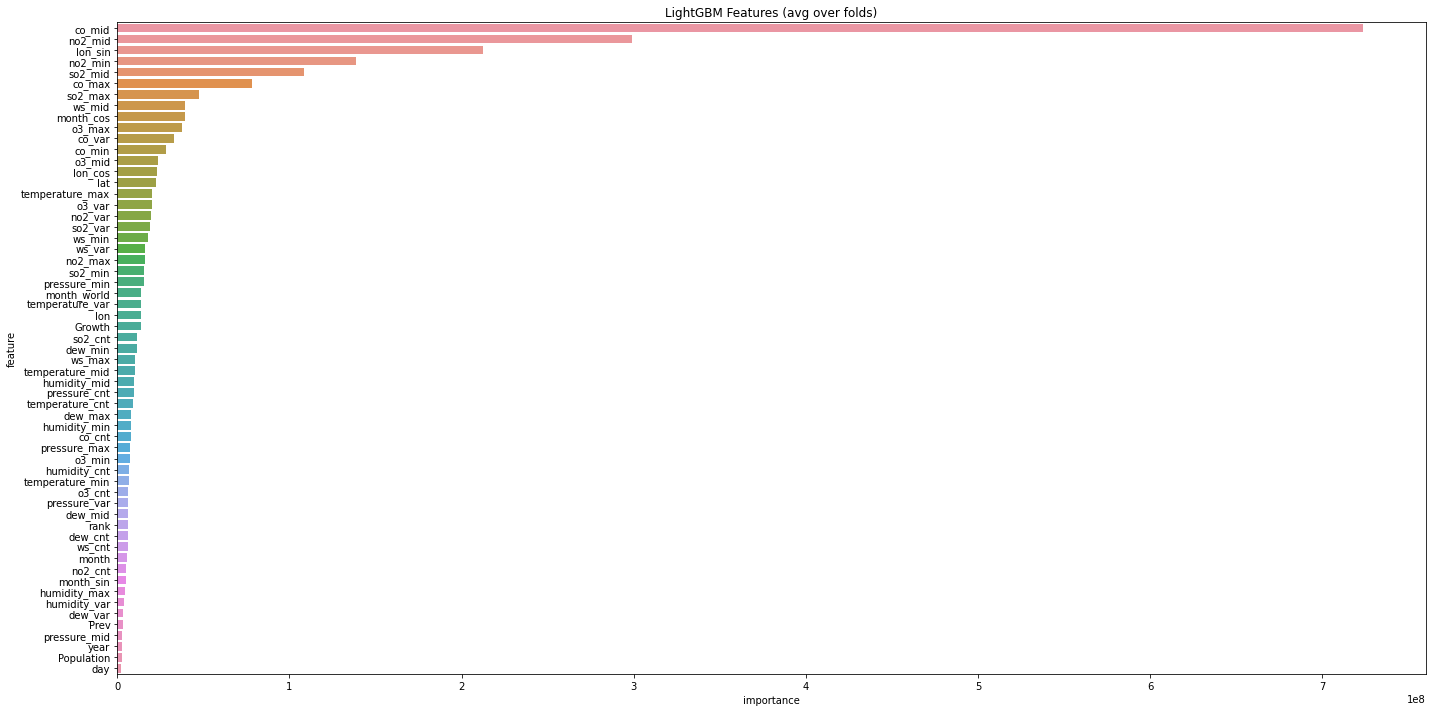

In [288]:
viz_feature_importances(feature_importance)

In [290]:
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], train_oof["oof"]))
oof_score = format(oof_score, ".3f")
print(f"oof score: {oof_score}")

# 22.332

oof score: 22.375


In [291]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

# predict

In [292]:
sum_predict = None
for model in models:
    predict = model.predict(
        test_df_[num_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(models)

In [293]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 57)


In [294]:
sample_df.loc[:,"predict"] = mean_predict

In [295]:
sample_df.head()

,id,predict
0,195942,22.547743
1,195943,36.271988
2,195944,23.735300
3,195945,66.591804
4,195946,128.805364


In [296]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

# submit

In [297]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [298]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [299]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:22.375_FP006-add-population'

# Submit

In [300]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.
